In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import zarr
import torch
import numpy as np
import wandb as wb
from ml_collections import ConfigDict
from tqdm import tqdm, trange
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from src.models.value import CriticModule
from src.dataset.dataset import OfflineRLFeatureDataset
from src.dataset.normalizer import StateActionNormalizer
from src.common.pytorch_util import dict_apply

In [3]:
api = wb.Api()
device = "cuda:0"
zarr_orig = zarr.open("/data/scratch/ankile/furniture-data/data/processed/sim/feature_small/vip/one_leg/data_new.zarr", mode="r")


In [43]:
def diagnose_critic(run_id, ylim=None):
    # Load the config file from the run
    run = api.run(f"robot-rearrangement/critic-module-test/{run_id}")
    config = ConfigDict(run.config)

    model_wts = [file for file in run.files() if file.name.endswith(".pt")][0]
    wts_path = model_wts.download(replace=False, exist_ok=True).name

    wts_path
    # Load the model
    critic = CriticModule(
        obs_dim=config.obs_dim,
        action_dim=config.action_dim,
        obs_horizon=config.obs_horizon,
        action_horizon=config.action_horizon,
        expectile=config.expectile,
        discount=config.discount,
        critic_hidden_dims=config.critic_hidden_dims,
        critic_dropout=config.critic_dropout,
        device=device,
    )

    critic.load_state_dict(torch.load(wts_path))
    critic.eval()

    # Turn off gradients
    for param in critic.parameters():
        param.requires_grad = False
    # Load in the dataset
    dataset = OfflineRLFeatureDataset(
        dataset_path=config.data_path,
        pred_horizon=config.pred_horizon,
        obs_horizon=config.obs_horizon,
        action_horizon=config.action_horizon,
        normalizer=StateActionNormalizer(),
    )

    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    end_idx = dataset.dataset["episode_ends"][0]
    end_idx
    # Set the random seed
    torch.manual_seed(69)

    # Loop over the first episode and calculate the Q-value along the trajectory
    q_values = []
    q_values_perturbed = []
    v_values = []

    obs_pert = 0
    action_pert = 1

    it = iter(loader)
    for i in trange(end_idx):
        batch = dict_apply(next(it), lambda x: x.to(device, non_blocking=True))

        # Calculate the Q-value
        nobs = critic._training_obs(batch["curr_obs"])
        naction = critic._flat_action(batch["action"])
        q_values.append(critic.q_value(nobs, naction).item())

        # Calculate the Q-value with perturbed action
        q_values_perturbed.append(
            critic.q_value(
                nobs + torch.rand_like(nobs) * obs_pert,
                naction + torch.rand_like(naction) * action_pert,
            ).item()
        )

        # Calculate the V-value
        v_values.append(critic.value(nobs).item())
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    for ax in axs:
        # Plot the Q-values
        ax.plot(q_values, label="Q-values")
        ax.plot(q_values_perturbed, label="Q-values (perturbed)")
        ax.plot(v_values, label="V-values")

        ax.set_xlabel("Time Step")

    axs[0].set_ylabel("Value")
    axs[0].legend()
    axs[1].set_ylim(ylim)

Total parameters: 66.38M
q_network: 26.60M parameters
q_target_network: 26.60M parameters
value_network: 13.17M parameters
Loading dataset of 699 episodes


100%|██████████| 590/590 [00:11<00:00, 51.75it/s]


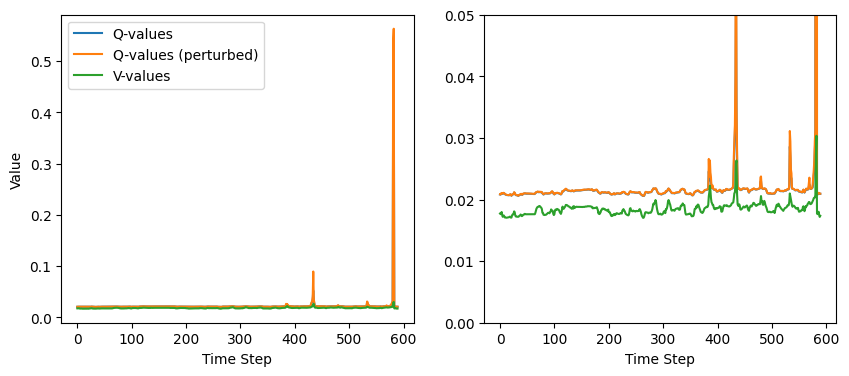

In [73]:
diagnose_critic(run_id="da006xn9", ylim=(0, 0.05))

## Make a dataset with only the last $n$ timesteps of each trajetory

In [75]:
n_timesteps = 32

In [76]:
# Copy all the keys and datasets from the original zarr to a new one
zarr_new = zarr.open("data_short.zarr", mode="w")

for key in tqdm(list(zarr_orig.keys())):
    # For each key, copy all the meta data for the dataset but not the data itself
    zarr_new.create_dataset(
        key, shape=(0,) + zarr_orig[key].shape[1:], dtype=zarr_orig[key].dtype
    )

100%|██████████| 9/9 [00:00<00:00, 367.60it/s]


In [77]:
# Loop over the episode ends and copy over the data from n before the end to the end for each key
curr_idx = 0
for i in trange(len(zarr_orig["episode_ends"])):
    end_idx = zarr_orig["episode_ends"][i]
    start_idx = end_idx - n_timesteps
    zarr_new["episode_ends"].append([curr_idx := curr_idx + n_timesteps])

    for key in ["action", "feature1", "feature2", "reward", "robot_state"]:
        zarr_new[key].append(zarr_orig[key][start_idx:end_idx])



  0%|          | 0/699 [00:00<?, ?it/s]

100%|██████████| 699/699 [02:27<00:00,  4.74it/s]


KeyError: 'terminal'

In [78]:
zarr_new.create_dataset("terminal", shape=zarr_new["reward"].shape, dtype=np.dtype("int"))

zarr_new["terminal"][:] = zarr_new["reward"][:]

ValueError: parameter 'value': expected array with shape (369535,), got (22368,)

### Run diagnostics on the resulting Critic from the short dataset

Total parameters: 66.38M
q_network: 26.60M parameters
q_target_network: 26.60M parameters
value_network: 13.17M parameters
Loading dataset of 699 episodes


100%|██████████| 32/32 [00:00<00:00, 155.77it/s]


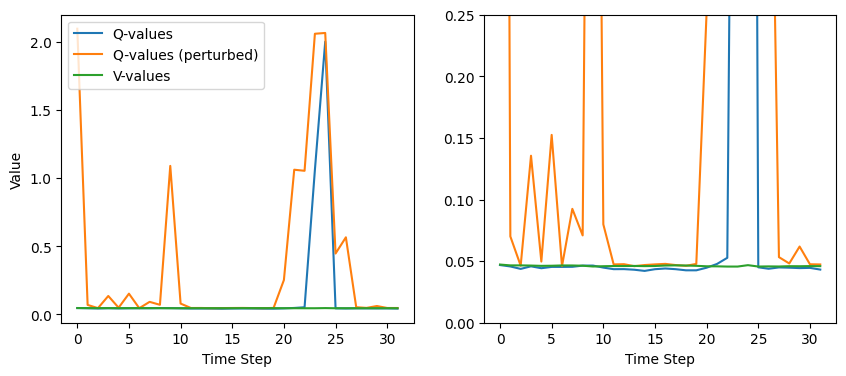

In [47]:
diagnose_critic(run_id="pskuazec", ylim=(0, 0.25))

## Make a dataset with synthetically dense rewards

In [66]:
discount = 0.997

In [67]:
# Copy all the keys and datasets from the original zarr to a new one
zarr_new = zarr.open("data_dense.zarr", mode="w")

for key in tqdm(["action", "feature1", "feature2", "reward", "robot_state", "episode_ends"]):
    # For each key, copy all the data from the original zarr
    zarr_new.create_dataset(
        key, shape=zarr_orig[key].shape, dtype=zarr_orig[key].dtype
    )

    # Insert the actual data
    zarr_new[key][:] = zarr_orig[key][:]


100%|██████████| 6/6 [00:30<00:00,  5.02s/it]


In [68]:
# Loop over the episode ends and for each episode, make the reward dense by setting each reward to be the discounted reward from the end of the episode
start_index = 0
for i in trange(len(zarr_orig["episode_ends"])):
    end_index = zarr_orig["episode_ends"][i]

    # Calculate the discounted reward
    rewards = zarr_orig["reward"][start_index:end_index]
    discounted_rewards = np.zeros_like(rewards)
    discounted_rewards[-1] = rewards[-1]
    for j in reversed(range(len(rewards) - 1)):
        discounted_rewards[j] = rewards[j] + discount * discounted_rewards[j + 1]

    # Set the rewards in the new zarr
    zarr_new["reward"][start_index:end_index] = discounted_rewards

    start_index = end_index

  0%|          | 0/699 [00:00<?, ?it/s]

100%|██████████| 699/699 [00:02<00:00, 250.93it/s]


In [69]:
# Add dataset for terminal and set it equal to the reward from the original zarr
zarr_new.create_dataset("terminal", shape=zarr_orig["reward"].shape, dtype=np.dtype("int"))
zarr_new["terminal"][:] = zarr_orig["reward"][:]

In [28]:
idx = zarr_new["episode_ends"][0]
zarr_new["reward"][:idx]

array([0.17039159, 0.17090431, 0.17141856, 0.17193437, 0.17245172,
       0.17297064, 0.1734911 , 0.17401314, 0.17453675, 0.17506194,
       0.17558871, 0.17611706, 0.17664701, 0.17717855, 0.17771168,
       0.17824642, 0.17878278, 0.17932074, 0.17986032, 0.18040153,
       0.18094437, 0.18148884, 0.18203494, 0.18258269, 0.18313208,
       0.18368313, 0.18423584, 0.18479021, 0.18534625, 0.18590395,
       0.18646334, 0.18702441, 0.18758717, 0.18815163, 0.18871778,
       0.18928564, 0.1898552 , 0.19042648, 0.19099948, 0.1915742 ,
       0.19215065, 0.19272883, 0.19330876, 0.19389042, 0.19447385,
       0.19505903, 0.19564597, 0.19623467, 0.19682515, 0.1974174 ,
       0.19801143, 0.19860725, 0.19920486, 0.19980428, 0.2004055 ,
       0.20100851, 0.20161335, 0.20222001, 0.2028285 , 0.20343882,
       0.20405097, 0.20466498, 0.20528081, 0.20589851, 0.20651807,
       0.20713949, 0.20776278, 0.20838794, 0.20901498, 0.20964392,
       0.21027474, 0.21090746, 0.21154208, 0.21217862, 0.21281

### Run diagnostics on the resulting Critic from the dense dataset

Total parameters: 66.38M
q_network: 26.60M parameters
q_target_network: 26.60M parameters
value_network: 13.17M parameters
Loading dataset of 699 episodes


100%|██████████| 590/590 [00:12<00:00, 46.19it/s]


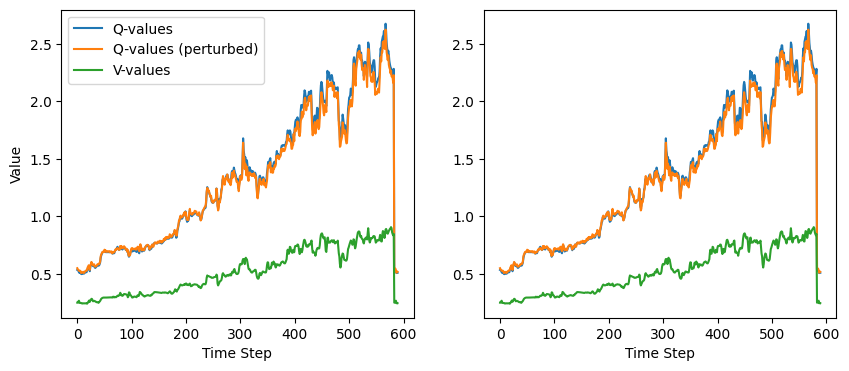

In [74]:
diagnose_critic(run_id="1phr216o")

## Make a dataset where each skilll boundary is a reward

In [70]:
# Copy all the keys and datasets from the original zarr to a new one
zarr_orig = zarr.open("/data/scratch/ankile/furniture-data/data/processed/sim/feature_small/vip/one_leg/data_new.zarr", mode="r")

zarr_new = zarr.open("data_skill.zarr", mode="w")

for key in tqdm(["action", "feature1", "feature2", "reward", "robot_state", "episode_ends"]):
    # For each key, copy all the data from the original zarr
    zarr_new.create_dataset(
        key, shape=zarr_orig[key].shape, dtype=zarr_orig[key].dtype
    )

    # Insert the actual data
    zarr_new[key][:] = zarr_orig[key][:]


100%|██████████| 6/6 [00:29<00:00,  4.98s/it]


In [71]:
# Copy the values from the skills data set in the original zarr to the reward dataset in the new zarr
zarr_new["reward"][:] = zarr_orig["skills"][:] + zarr_orig["reward"][:]

# Add dataset for terminal and set it equal to the reward from the original zarr
zarr_new.create_dataset("terminal", shape=zarr_orig["reward"].shape, dtype=np.dtype("int"))
zarr_new["terminal"][:] = zarr_orig["reward"][:]

In [36]:
zarr_new["reward"][:590].sum()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Run diagnostics on the resulting Critic from the skill dataset

Total parameters: 66.38M
q_network: 26.60M parameters
q_target_network: 26.60M parameters
value_network: 13.17M parameters
Loading dataset of 699 episodes


100%|██████████| 590/590 [00:03<00:00, 171.27it/s]


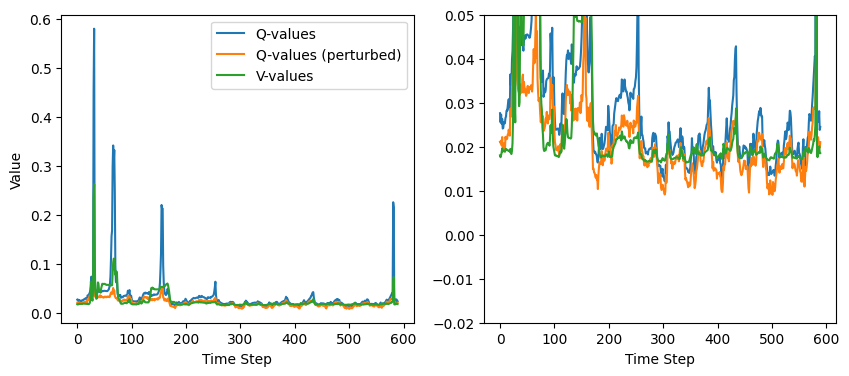

In [53]:
diagnose_critic(run_id="b2t6ex7h", ylim=(-0.02, 0.05))

## Make a dataset with terminal state indicator

In [61]:
# Copy all the keys and datasets from the original zarr to a new one
zarr_new = zarr.open("data_terminal.zarr", mode="w")

for key in tqdm(["action", "feature1", "feature2", "reward", "robot_state", "episode_ends"]):
    # For each key, copy all the data from the original zarr
    zarr_new.create_dataset(
        key, shape=zarr_orig[key].shape, dtype=zarr_orig[key].dtype
    )

    # Insert the actual data
    zarr_new[key][:] = zarr_orig[key][:]


100%|██████████| 6/6 [00:30<00:00,  5.11s/it]


In [62]:
# Add dataset for terminal and set it equal to the reward from the original zarr
zarr_new.create_dataset("terminal", shape=zarr_orig["reward"].shape, dtype=np.dtype("int"))
zarr_new["terminal"][:] = zarr_orig["reward"][:]

### Run diagnostics on the resulting Critic from the short dataset

Total parameters: 66.38M
q_network: 26.60M parameters
q_target_network: 26.60M parameters
value_network: 13.17M parameters
Loading dataset of 699 episodes


100%|██████████| 32/32 [00:00<00:00, 155.77it/s]


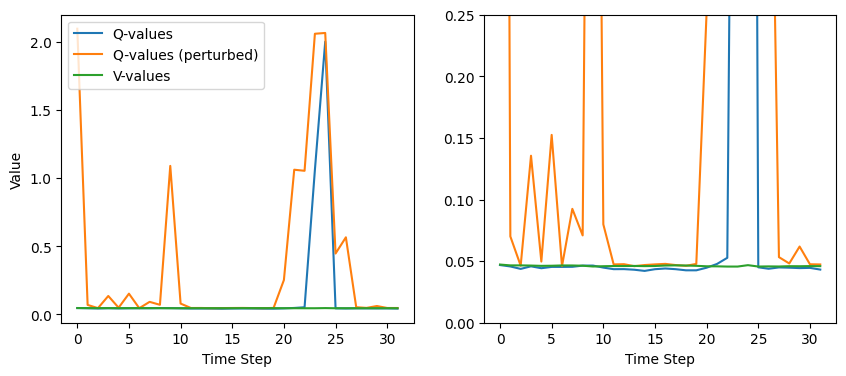

In [ ]:
diagnose_critic(run_id="pskuazec", ylim=(0, 0.25))

In [ ]:
discount = 0.997

In [ ]:
# Copy all the keys and datasets from the original zarr to a new one
zarr_new = zarr.open("data_dense.zarr", mode="w")

for key in tqdm(["action", "feature1", "feature2", "reward", "robot_state", "episode_ends"]):
    # For each key, copy all the data from the original zarr
    zarr_new.create_dataset(
        key, shape=zarr_orig[key].shape, dtype=zarr_orig[key].dtype
    )

    # Insert the actual data
    zarr_new[key][:] = zarr_orig[key][:]


100%|██████████| 6/6 [00:30<00:00,  5.12s/it]


In [ ]:
# Loop over the episode ends and for each episode, make the reward dense by setting each reward to be the discounted reward from the end of the episode
start_index = 0
for i in trange(len(zarr_orig["episode_ends"])):
    end_index = zarr_orig["episode_ends"][i]

    # Calculate the discounted reward
    rewards = zarr_orig["reward"][start_index:end_index]
    discounted_rewards = np.zeros_like(rewards)
    discounted_rewards[-1] = rewards[-1]
    for j in reversed(range(len(rewards) - 1)):
        discounted_rewards[j] = rewards[j] + discount * discounted_rewards[j + 1]

    # Set the rewards in the new zarr
    zarr_new["reward"][start_index:end_index] = discounted_rewards

    start_index = end_index

  0%|          | 0/699 [00:00<?, ?it/s]

100%|██████████| 699/699 [00:02<00:00, 235.07it/s]


In [ ]:
idx = zarr_new["episode_ends"][0]
zarr_new["reward"][:idx]

array([0.17039159, 0.17090431, 0.17141856, 0.17193437, 0.17245172,
       0.17297064, 0.1734911 , 0.17401314, 0.17453675, 0.17506194,
       0.17558871, 0.17611706, 0.17664701, 0.17717855, 0.17771168,
       0.17824642, 0.17878278, 0.17932074, 0.17986032, 0.18040153,
       0.18094437, 0.18148884, 0.18203494, 0.18258269, 0.18313208,
       0.18368313, 0.18423584, 0.18479021, 0.18534625, 0.18590395,
       0.18646334, 0.18702441, 0.18758717, 0.18815163, 0.18871778,
       0.18928564, 0.1898552 , 0.19042648, 0.19099948, 0.1915742 ,
       0.19215065, 0.19272883, 0.19330876, 0.19389042, 0.19447385,
       0.19505903, 0.19564597, 0.19623467, 0.19682515, 0.1974174 ,
       0.19801143, 0.19860725, 0.19920486, 0.19980428, 0.2004055 ,
       0.20100851, 0.20161335, 0.20222001, 0.2028285 , 0.20343882,
       0.20405097, 0.20466498, 0.20528081, 0.20589851, 0.20651807,
       0.20713949, 0.20776278, 0.20838794, 0.20901498, 0.20964392,
       0.21027474, 0.21090746, 0.21154208, 0.21217862, 0.21281

### Run diagnostics on the resulting Critic from the dense dataset

Total parameters: 66.38M
q_network: 26.60M parameters
q_target_network: 26.60M parameters
value_network: 13.17M parameters
Loading dataset of 699 episodes


100%|██████████| 590/590 [00:03<00:00, 173.38it/s]


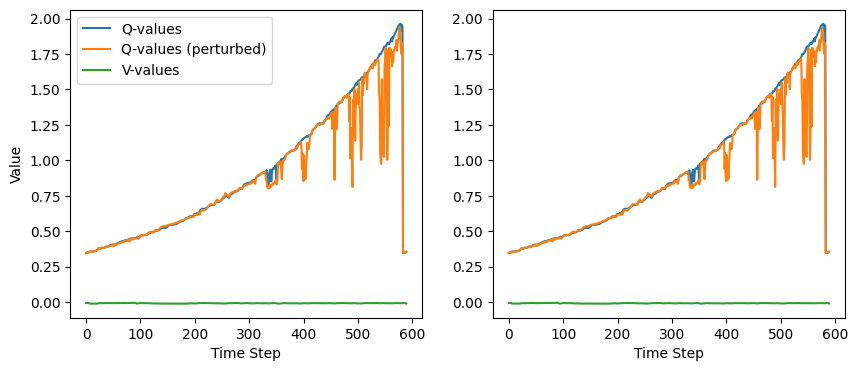

In [ ]:
diagnose_critic(run_id="c5hxuq1q")

In [ ]:
# Copy all the keys and datasets from the original zarr to a new one
zarr_orig = zarr.open("/data/scratch/ankile/furniture-data/data/processed/sim/feature_small/vip/one_leg/data_new.zarr", mode="r")

zarr_new = zarr.open("data_skill.zarr", mode="w")

for key in tqdm(["action", "feature1", "feature2", "reward", "robot_state", "episode_ends"]):
    # For each key, copy all the data from the original zarr
    zarr_new.create_dataset(
        key, shape=zarr_orig[key].shape, dtype=zarr_orig[key].dtype
    )

    # Insert the actual data
    zarr_new[key][:] = zarr_orig[key][:]


100%|██████████| 6/6 [00:29<00:00,  4.92s/it]


In [ ]:
# Copy the values from the skills data set in the original zarr to the reward dataset in the new zarr
zarr_new["reward"][:] = zarr_orig["skills"][:] + zarr_orig["reward"][:]